In [1]:
from pathlib import Path
from typing import Optional

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [3]:
list(benchmark_dir.iterdir())

[PosixPath('../benchmarks/010_010_run-crc-sampling-snakemake'),
 PosixPath('../benchmarks/012_010_simulation-based-calibration-snakemake')]

In [4]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,189.8387,0:03:09,1599.40,2327.29,1596.87,1596.96,1025.21,5.09,31.49,59.88,simple-default_MCMC_perm168,run_sbc,012_010_simulation-based-calibration-snakemake
1,1394.6028,0:23:14,13024.31,17736.92,2819.38,2819.44,764.14,173.55,291.99,116.36,sp2-default_MCMC_perm106,run_sbc,012_010_simulation-based-calibration-snakemake
2,210.3181,0:03:30,1550.02,2271.32,1547.41,1547.47,5.54,37.25,29.33,61.68,simple-default_MCMC_perm369,run_sbc,012_010_simulation-based-calibration-snakemake
3,145.9928,0:02:25,1470.88,2192.43,1468.29,1468.34,5.94,109.27,43.57,63.86,simple-default_MCMC_perm789,run_sbc,012_010_simulation-based-calibration-snakemake
4,132.1361,0:02:12,1361.04,2094.03,1358.61,1358.68,2.88,5.08,35.23,46.97,simple-default_MCMC_perm140,run_sbc,012_010_simulation-based-calibration-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [5]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  \
pipeline                                       rule                          
012_010_simulation-based-calibration-snakemake collate_sbc          349.97   
                                               generate_mockdata     10.37   
                                               run_sbc              468.31   
                                               sbc_uniformity_test  426.45   

                                                                    max_rss  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           449.04   
                                               generate_mockdata     217.25   
                                               run_sbc              5678.15   
                                               sbc_uniformity_test  3051.67   

                                                                    max_vms  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc          2958.43   
                                               generate_mockdata     826.30   
                                               run_sbc              7866.74   
                                               sbc_uniformity_test  4950.30   

                                                                    max_uss  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           447.12   
                                               generate_mockdata     214.76   
                                               run_sbc              1954.82   
                                               sbc_uniformity_test  3049.61   

                                                                    max_pss  \
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc           447.18   
                                               generate_mockdata     214.82   
                                               run_sbc              1960.67   
                                               sbc_uniformity_test  3049.65   

                                                                       io_in  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc           8047.58   
                                               generate_mockdata      211.50   
                                               run_sbc                150.24   
                                               sbc_uniformity_test  15221.14   

                                                                    io_out  \
pipeline                                       rule                          
012_010_simulation-based-calibration-snakemake collate_sbc            0.26   
                                               generate_mockdata      0.27   
                                               run_sbc               79.93   
                                               sbc_uniformity_test    0.15   

                                                                    mean_load  \
pipeline                                       rule                             
012_010_simulation-based-calibration-snakemake collate_sbc              42.32   
                                               generate_mockdata        34.63   
                                               run_sbc                 107.71   
                                               sbc_uniformity_test      46.53   

                                                                    cpu_time  
pipeline                                       rule                           
012_010_simulation-based-calibration-snakemake collate_sbc            147.87  
                              

In [6]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,012_010_simulation-based-calibration-snakemake,run_sbc,simple-default_MCMC_perm168,cpu_time,59.88
1,012_010_simulation-based-calibration-snakemake,run_sbc,sp2-default_MCMC_perm106,cpu_time,116.36
2,012_010_simulation-based-calibration-snakemake,run_sbc,simple-default_MCMC_perm369,cpu_time,61.68
3,012_010_simulation-based-calibration-snakemake,run_sbc,simple-default_MCMC_perm789,cpu_time,63.86
4,012_010_simulation-based-calibration-snakemake,run_sbc,simple-default_MCMC_perm140,cpu_time,46.97


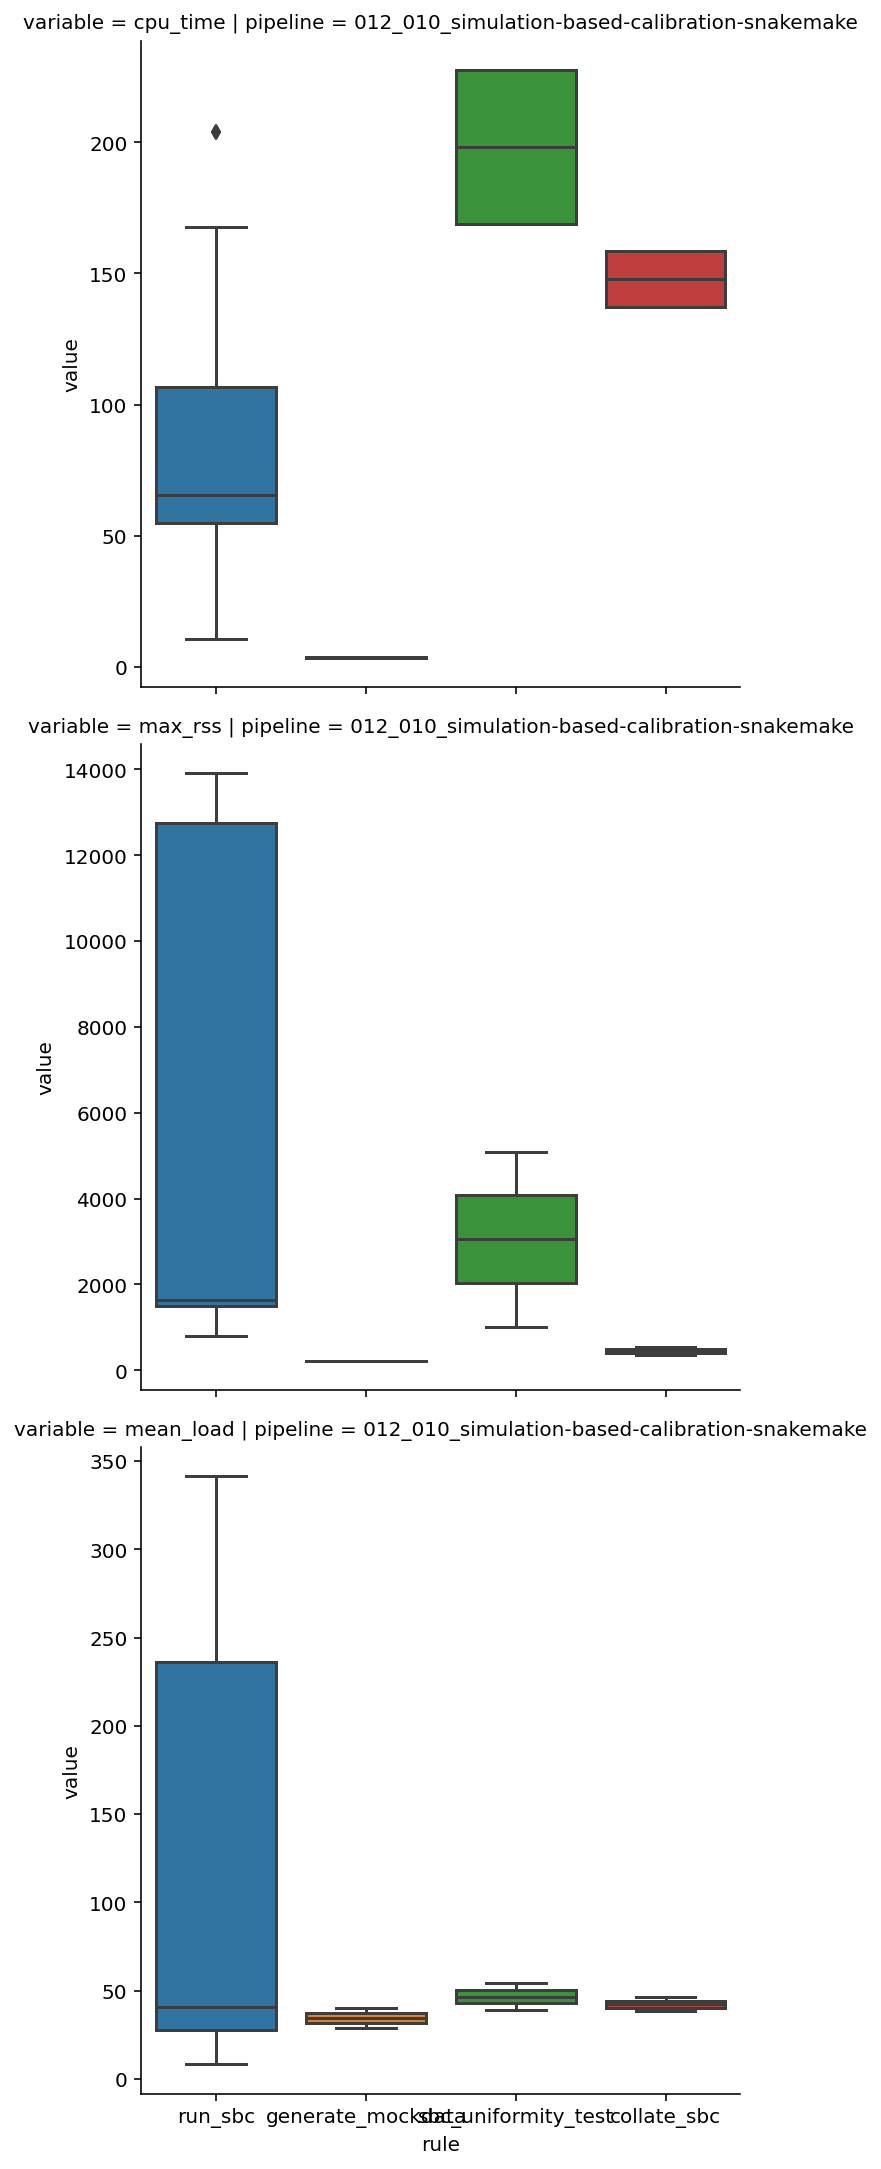

In [7]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-08-14

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-160.o2.rc.hms.harvard.edu

Git branch: speclet-simple

janitor : 0.21.0
seaborn : 0.11.1
pandas  : 1.3.0
plotnine: 0.8.0

